<a href="https://colab.research.google.com/github/xqyn/CAMCAN/blob/main/PhS_predictive_models_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats, linalg
from sklearn import preprocessing, decomposition, linear_model, metrics 
from sklearn.model_selection import train_test_split
import warnings

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# 1.Load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
content_dir = '/content/'

In [ ]:
proc_dir = '/content/drive/MyDrive/CAMCAN/data/'

In [ ]:
# Import z-score
phs_z = pd.read_csv(os.path.join(proc_dir,'phs_Z.csv'))

#Z-score datasets:
# Remove first columns
phs_z.drop(columns=phs_z.columns[0], axis=1, inplace=True)
# Remove sub
phs_z['participant_id'] = phs_z['participant_id'].map(lambda x: x.lstrip('sub-'))
# Sort by subjects
phs_z = phs_z.sort_values(by ='participant_id')
# Reset index
phs_z.reset_index(drop=True, inplace=True)

phs_z

,participant_id,3rd-Ventricle_Z_estimate,lh_S_postcentral_thickness_Z_estimate,rh_G&S_frontomargin_thickness_Z_estimate,rh_G_pariet_inf-Supramar_thickness_Z_estimate,rh_S_temporal_transverse_thickness_Z_estimate,lh_S_oc_middle&Lunatus_thickness_Z_estimate,lh_S_cingul-Marginalis_thickness_Z_estimate,rh_G_oc-temp_lat-fusifor_thickness_Z_estimate,rh_G_temp_sup-Lateral_thickness_Z_estimate,...,lh_Pole_temporal_thickness_Z_estimate,rh_G_cuneus_thickness_Z_estimate,rh_S_temporal_sup_thickness_Z_estimate,lh_Lat_Fis-ant-Horizont_thickness_Z_estimate,rh_S_interm_prim-Jensen_thickness_Z_estimate,lh_S_pericallosal_thickness_Z_estimate,lh_S_occipital_ant_thickness_Z_estimate,lh_S_oc-temp_lat_thickness_Z_estimate,rh_G_oc-temp_med-Lingual_thickness_Z_estimate,lh_S_temporal_inf_thickness_Z_estimate
0,600009963128,-0.035788,1.684554,-1.200199,-0.363325,-1.138707,1.097066,1.966251,-0.858721,-1.031426,...,-0.044689,-0.400939,0.660543,-0.711965,1.669121,-0.111204,0.565492,-0.023525,-0.175776,0.350362
1,600018902293,-0.002102,-0.560987,-2.111576,-0.740936,0.044502,-0.229342,-0.695656,-0.060189,-0.857179,...,-0.866884,-1.226048,-0.840637,-1.279448,-1.357197,-0.117540,-1.552017,-0.727067,-0.923016,-0.451566
2,600020364885,-0.359971,0.059189,0.453107,1.609973,1.032618,-0.149416,-0.321483,0.989817,0.335978,...,1.060574,-0.351085,0.320789,-0.130909,-0.829276,0.083198,0.254976,0.350755,0.923214,0.573105
3,600020927179,0.447179,-1.448274,-1.244801,-0.569734,0.127040,-0.281450,-0.967629,-1.106707,-0.415901,...,-1.145101,-0.746889,-1.647499,0.674791,-1.947899,-0.319015,-0.559485,-1.054573,0.988569,-0.223733
4,600031697545,-0.084905,0.014956,0.139993,-1.001396,-1.583552,-0.550614,-0.745864,-0.124503,-0.251363,...,1.948272,0.253143,-1.119213,0.168410,-0.706087,-0.435348,-2.354768,-0.923589,0.329893,1.382673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,609987242768,-0.911355,-0.481095,-0.160522,0.169986,-1.303410,0.274354,0.044843,0.164932,-1.058351,...,-0.095498,-0.414880,-0.333767,-0.675066,0.050761,2.774540,-0.007690,-0.193580,-0.589093,0.224487
1006,609987705265,-0.209376,0.749046,-0.761692,-0.690309,-1.740693,-0.245832,0.555419,-0.430877,0.731627,...,-0.900884,-1.117408,0.423636,-0.647056,-0.299684,-1.015499,0.696099,-0.602203,-0.978139,-0.126396
1007,609989574966,0.428788,-1.001288,0.360900,-0.699186,0.932965,0.379283,-1.219109,-0.428165,-1.325444,...,0.294182,-1.373930,0.362282,-1.645341,-0.549632,-1.317312,-1.217066,-0.561617,-0.216882,-1.192912
1008,609990435049,0.354481,0.321398,-0.758452,-0.895990,-0.541966,-0.805403,-0.335189,-0.984951,0.104103,...,0.723692,-1.174911,-0.962837,-1.482529,-0.444006,-1.652926,-0.824610,0.559954,-1.711201,-0.338178


In [ ]:
# Import PC1 of phs data
phs_pc = pd.read_csv(os.path.join(proc_dir,'phs_R_DD_pca.csv'))
phs_pc.head()

,SUBJID,PC1,PC2,PC3,PC4,PC5
0,600009963128,-1.394306,-1.219576,-0.556390,-0.173447,0.078096
1,600018902293,-0.584351,-0.003281,0.210825,-0.230257,0.358502
2,600020364885,-1.127396,-0.954937,-0.409449,-0.266499,0.104410
3,600020927179,-0.908754,-0.373142,-0.026416,-0.316577,-0.835821
4,600031697545,1.651496,2.830077,0.692184,-0.076574,-0.105002


In [ ]:
# Check where the two datasets are really match with the other
phs_z['participant_id'].astype(int).equals(phs_pc['SUBJID'].astype(int) )

True

In [ ]:
# Remove subject ID in phs Z score datasets:
del phs_z['participant_id']
phs_z.head()

,3rd-Ventricle_Z_estimate,lh_S_postcentral_thickness_Z_estimate,rh_G&S_frontomargin_thickness_Z_estimate,rh_G_pariet_inf-Supramar_thickness_Z_estimate,rh_S_temporal_transverse_thickness_Z_estimate,lh_S_oc_middle&Lunatus_thickness_Z_estimate,lh_S_cingul-Marginalis_thickness_Z_estimate,rh_G_oc-temp_lat-fusifor_thickness_Z_estimate,rh_G_temp_sup-Lateral_thickness_Z_estimate,rh_S_circular_insula_sup_thickness_Z_estimate,...,lh_Pole_temporal_thickness_Z_estimate,rh_G_cuneus_thickness_Z_estimate,rh_S_temporal_sup_thickness_Z_estimate,lh_Lat_Fis-ant-Horizont_thickness_Z_estimate,rh_S_interm_prim-Jensen_thickness_Z_estimate,lh_S_pericallosal_thickness_Z_estimate,lh_S_occipital_ant_thickness_Z_estimate,lh_S_oc-temp_lat_thickness_Z_estimate,rh_G_oc-temp_med-Lingual_thickness_Z_estimate,lh_S_temporal_inf_thickness_Z_estimate
0,-0.035788,1.684554,-1.200199,-0.363325,-1.138707,1.097066,1.966251,-0.858721,-1.031426,0.979420,...,-0.044689,-0.400939,0.660543,-0.711965,1.669121,-0.111204,0.565492,-0.023525,-0.175776,0.350362
1,-0.002102,-0.560987,-2.111576,-0.740936,0.044502,-0.229342,-0.695656,-0.060189,-0.857179,0.978860,...,-0.866884,-1.226048,-0.840637,-1.279448,-1.357197,-0.117540,-1.552017,-0.727067,-0.923016,-0.451566
2,-0.359971,0.059189,0.453107,1.609973,1.032618,-0.149416,-0.321483,0.989817,0.335978,-0.301970,...,1.060574,-0.351085,0.320789,-0.130909,-0.829276,0.083198,0.254976,0.350755,0.923214,0.573105
3,0.447179,-1.448274,-1.244801,-0.569734,0.127040,-0.281450,-0.967629,-1.106707,-0.415901,-0.143192,...,-1.145101,-0.746889,-1.647499,0.674791,-1.947899,-0.319015,-0.559485,-1.054573,0.988569,-0.223733
4,-0.084905,0.014956,0.139993,-1.001396,-1.583552,-0.550614,-0.745864,-0.124503,-0.251363,-1.375025,...,1.948272,0.253143,-1.119213,0.168410,-0.706087,-0.435348,-2.354768,-0.923589,0.329893,1.382673


# 2.Split data

In [ ]:
# Spliting dataset into train and test:
phs_tr, phs_te = train_test_split(phs_z,
                                  test_size=0.40,
                                  random_state=1)
print("Training PhS size is: ", phs_tr.shape)
print("Testing PhS size is: ", phs_te.shape)

Training PhS size is:  (606, 199)
Testing PhS size is:  (404, 199)


In [ ]:
# Choose only PC1
phs_pc = phs_pc[['PC1']]
phs_pc.head()

,PC1
0,-1.394306
1,-0.584351
2,-1.127396
3,-0.908754
4,1.651496


In [ ]:
# Spliting PC data into training and tesing data based on index value:
phs_pc_tr = phs_pc.iloc[phs_tr.index.values.tolist()]
print(phs_pc_tr.shape)
phs_pc_te = phs_pc.iloc[phs_te.index.values.tolist()]
print(phs_pc_te.shape)

# reset idx
phs_tr.reset_index(drop=True, inplace=True)
phs_te.reset_index(drop=True, inplace=True)
phs_pc_tr.reset_index(drop=True, inplace=True)
phs_pc_te.reset_index(drop=True, inplace=True)

(606, 1)
(404, 1)


# 2.Manhattan plot:

In [ ]:
from scipy import stats

In [ ]:
Pvalue = pd.DataFrame()
phs_z.columns = phs_z.columns.str.replace(r'_Z_estimate', '')
X = pd.concat([phs_pc,phs_z], axis=1)

for roi in phs_z.columns:
  df=X[['PC1',roi]]
  #df = df.dropna()
  r,p=stats.spearmanr(df['PC1'],df[roi])
  pvalue=pd.DataFrame(columns=['Brain-regions'],
                      data=[roi])
  #pvalue['PC1']=[-np.log10(p)]
  pvalue[['corr']]=r
  pvalue[['p-value']]=p
  pvalue[['p-value(-log10)']]=-np.log10(p)
  #pvalue[['p-value(log10)']]=np.log10(p)
  Pvalue=pd.concat([Pvalue,pvalue])
Pvalue
Pvalue=Pvalue.reset_index()
Pvalue[['bonferroni']]='non-significant'

In [ ]:
ind = Pvalue[Pvalue['p-value'] < .05/len(Pvalue)].index
Pvalue.loc[ind, 'bonferroni'] = 'significant'

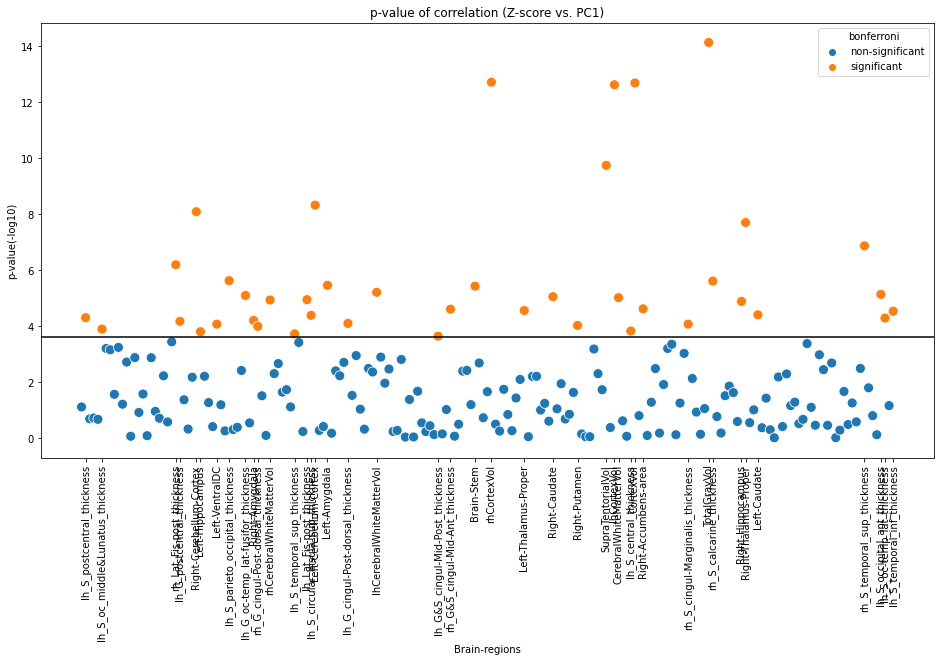

In [ ]:
plt.figure(figsize=(16,8))
fig=sns.scatterplot(data=Pvalue, x='Brain-regions',y='p-value(-log10)',hue="bonferroni",s=100)
#fig=sns.scatterplot(data=Pvalue, x='Brain-regions',y='p-value',hue="bonferroni",s=100)
fig.axhline(-np.log10(.05/len(Pvalue)),color='k')
#fig.set(xticks=[3, 5, 6, 7, 9], xticklabels=[30, 60, 90, 120, 150])
fig.set(xticks=ind, xticklabels=Pvalue['Brain-regions'][ind])
#ax.set_yscale('log')
#plt.yscale('symlog')
plt.title('p-value of correlation (Z-score vs. PC1)')
plt.xticks(rotation = 90)

plt.show()
plt.close()

In [ ]:
Pvalue

,index,Brain-regions,corr,p-value,p-value(-log10),bonferroni
0,0,3rd-Ventricle,-0.055766,0.076485,1.116424,non-significant
1,0,lh_S_postcentral_thickness,-0.127318,0.000050,4.304939,significant
2,0,rh_G&S_frontomargin_thickness,0.040105,0.202845,0.692837,non-significant
3,0,rh_G_pariet_inf-Supramar_thickness,-0.041326,0.189419,0.722575,non-significant
4,0,rh_S_temporal_transverse_thickness,-0.039398,0.210926,0.675870,non-significant
...,...,...,...,...,...,...
194,0,lh_S_pericallosal_thickness,-0.010097,0.748599,0.125751,non-significant
195,0,lh_S_occipital_ant_thickness,-0.140611,0.000007,5.138151,significant
196,0,lh_S_oc-temp_lat_thickness,-0.127089,0.000051,4.291308,significant
197,0,rh_G_oc-temp_med-Lingual_thickness,-0.057394,0.068265,1.165799,non-significant


In [ ]:
Pvalue2 = Pvalue
#Pvalue2['corr'] = Pvalue['corr'].abs()
Pvalue2

,index,Brain-regions,corr,p-value,p-value(-log10),bonferroni
0,0,3rd-Ventricle,-0.055766,0.076485,1.116424,non-significant
1,0,lh_S_postcentral_thickness,-0.127318,0.000050,4.304939,significant
2,0,rh_G&S_frontomargin_thickness,0.040105,0.202845,0.692837,non-significant
3,0,rh_G_pariet_inf-Supramar_thickness,-0.041326,0.189419,0.722575,non-significant
4,0,rh_S_temporal_transverse_thickness,-0.039398,0.210926,0.675870,non-significant
...,...,...,...,...,...,...
194,0,lh_S_pericallosal_thickness,-0.010097,0.748599,0.125751,non-significant
195,0,lh_S_occipital_ant_thickness,-0.140611,0.000007,5.138151,significant
196,0,lh_S_oc-temp_lat_thickness,-0.127089,0.000051,4.291308,significant
197,0,rh_G_oc-temp_med-Lingual_thickness,-0.057394,0.068265,1.165799,non-significant


In [ ]:
Pvalue2[0:20]

,index,Brain-regions,corr,p-value,p-value(-log10),bonferroni
0,0,3rd-Ventricle,-0.055766,0.076485,1.116424,non-significant
1,0,lh_S_postcentral_thickness,-0.127318,0.000050,4.304939,significant
2,0,rh_G&S_frontomargin_thickness,0.040105,0.202845,0.692837,non-significant
3,0,rh_G_pariet_inf-Supramar_thickness,-0.041326,0.189419,0.722575,non-significant
4,0,rh_S_temporal_transverse_thickness,-0.039398,0.210926,0.675870,non-significant
5,0,lh_S_oc_middle&Lunatus_thickness,-0.120320,0.000127,3.897636,significant
6,0,lh_S_cingul-Marginalis_thickness,-0.107494,0.000622,3.206317,non-significant
7,0,rh_G_oc-temp_lat-fusifor_thickness,-0.106566,0.000693,3.159054,non-significant
8,0,rh_G_temp_sup-Lateral_thickness,-0.069595,0.026986,1.568854,non-significant
9,0,rh_S_circular_insula_sup_thickness,-0.108233,0.000570,3.244211,non-significant


In [ ]:
#ttt.sort_values(by='B', key=abs)
Pvalue2 = Pvalue.sort_values('p-value(-log10)', key=abs, ascending=False)
Pvalue2[0:20]

,index,Brain-regions,corr,p-value,p-value(-log10),bonferroni
153,0,TotalGrayVol,-0.241413,7.365106e-15,14.132821,significant
100,0,rhCortexVol,-0.228596,1.931276e-13,12.714156,significant
135,0,CortexVol,-0.228337,2.058705e-13,12.686406,significant
130,0,lhCortexVol,-0.227735,2.388666e-13,12.621845,significant
128,0,SupraTentorialVol,-0.198910,1.800400e-10,9.744631,significant
57,0,Left-Cerebellum-Cortex,-0.182923,4.751297e-09,8.323188,significant
28,0,Right-Cerebellum-Cortex,-0.180149,8.148554e-09,8.088919,significant
162,0,Right-Thalamus-Proper,-0.175476,1.983763e-08,7.702510,significant
191,0,rh_S_temporal_sup_thickness,-0.164956,1.349117e-07,6.869950,significant
23,0,rh_Lat_Fis-post_thickness,-0.155900,6.394522e-07,6.194192,significant


In [ ]:
sum(Pvalue2['bonferroni'] == 'significant')

42

In [ ]:
Pvalue2.to_csv(os.path.join('/content/', 'Pvalue2.csv'), index=None)

In [ ]:
ind2 = Pvalue2[0:10].index
ind2

Int64Index([153, 100, 135, 130, 128, 57, 28, 162, 191, 23], dtype='int64')

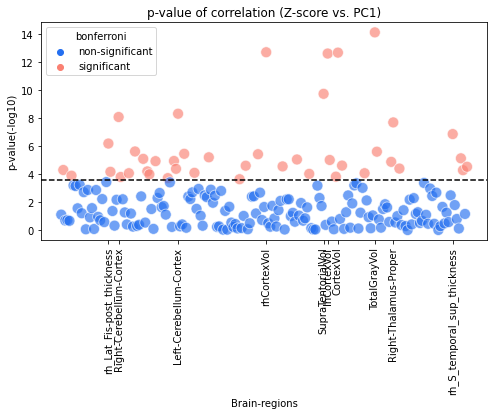

In [ ]:
plt.figure(figsize=(8,4))
fig=sns.scatterplot(data=Pvalue, x='Brain-regions',y='p-value(-log10)',hue="bonferroni",s=120,
                    palette=['#246FF0','#FA8072'], alpha = 0.65, legend='full')
#fig=sns.scatterplot(data=Pvalue, x='Brain-regions',y='p-value',hue="bonferroni",s=100)
fig.axhline(-np.log10(.05/len(Pvalue)),color='k', linestyle='--')
fig.set(xticks=ind2, xticklabels=Pvalue['Brain-regions'][ind2])
plt.title('p-value of correlation (Z-score vs. PC1)')
plt.xticks(rotation = 90, fontsize= 10)
plt.savefig('/content/', bbox_inches='tight')
plt.show()


In [ ]:
Pvalue

,index,Brain-regions,corr,p-value,p-value(-log10),bonferroni
0,0,3rd-Ventricle,-0.055766,0.076485,1.116424,non-significant
1,0,lh_S_postcentral_thickness,-0.127318,0.000050,4.304939,significant
2,0,rh_G&S_frontomargin_thickness,0.040105,0.202845,0.692837,non-significant
3,0,rh_G_pariet_inf-Supramar_thickness,-0.041326,0.189419,0.722575,non-significant
4,0,rh_S_temporal_transverse_thickness,-0.039398,0.210926,0.675870,non-significant
...,...,...,...,...,...,...
194,0,lh_S_pericallosal_thickness,-0.010097,0.748599,0.125751,non-significant
195,0,lh_S_occipital_ant_thickness,-0.140611,0.000007,5.138151,significant
196,0,lh_S_oc-temp_lat_thickness,-0.127089,0.000051,4.291308,significant
197,0,rh_G_oc-temp_med-Lingual_thickness,-0.057394,0.068265,1.165799,non-significant


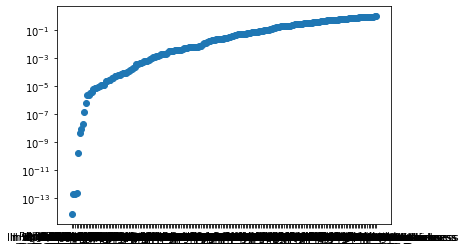

In [ ]:
fig, ax = plt.subplots()
ax.scatter(Pvalue['Brain-regions'], Pvalue['p-value'])
ax.set_yscale('log')

# 3.Linear Regression

Fit Linear Regression Model

In [ ]:
%%capture
# Using linear algebra
# fit ols model on full training data
# Add intercept for training
phs_tr_feature = np.hstack([np.ones((phs_tr.shape[0], 1)), 
                            phs_tr])
# Inverse matrix
phs_tr_feature_inv = linalg.pinv2(phs_tr_feature)
# Compute beta as covariate for training dataset (z-score), response variable (pc1 of phenotype data)
phs_beta = np.dot(phs_tr_feature_inv, phs_pc_tr)
# Predict y hat based on computed beta
phs_pc_tr_pred = np.dot(phs_tr_feature, phs_beta)


# Add intercept for testing
phs_te_feature = np.hstack([np.ones((phs_te.shape[0], 1)), 
                           phs_te])
# Using beta above for testing data
phs_pc_te_pred = np.dot(phs_te_feature, phs_beta)

print(phs_tr_feature.shape)
print(phs_pc_tr_pred.shape)
print(phs_te_feature.shape)
print(phs_pc_te_pred.shape)

print(phs_tr.shape)
print(phs_pc_tr.shape)

In [ ]:
# OLS using sklearn
lr_model = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lr_model.fit(phs_tr, phs_pc_tr)
phs_pc_tr_lr_pred = lr_model.predict(phs_tr)
phs_pc_te_lr_pred = lr_model.predict(phs_te)

print(phs_pc_tr_lr_pred.shape)
print(phs_pc_te_lr_pred.shape)

(606, 1)
(404, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


In [ ]:
# ensure matrix math predictions and sklearn predictions are accurate to 5 decimals
assert np.allclose(np.round(phs_pc_tr_pred - phs_pc_tr_lr_pred, 5), 0), 'Failed'
assert np.allclose(np.round(phs_pc_te_pred - phs_pc_te_lr_pred, 5), 0), 'Failed'
print('Passed')

Passed


Mean Squared/Absolute Error of Predictions

In [ ]:
train_r2_z = metrics.r2_score(phs_pc_tr, phs_pc_tr_lr_pred)
test_r2_z = metrics.r2_score(phs_pc_te, phs_pc_te_lr_pred)
train_mae_z = metrics.mean_absolute_error(phs_pc_tr, phs_pc_tr_lr_pred)
test_mae_z = metrics.mean_absolute_error(phs_pc_te, phs_pc_te_lr_pred)
train_mse_z = metrics.mean_squared_error(phs_pc_tr, phs_pc_tr_lr_pred)
test_mse_z = metrics.mean_squared_error(phs_pc_te, phs_pc_te_lr_pred)
print(f'Deviation model Train R^2: {train_r2_z:.3f}')
print(f'Deviation model Train R^2: {test_r2_z:.3f}')
print(f'Deviation model Train MAE: {train_mae_z:.3f}')
print(f'Deviation model Test MAE: {test_mae_z:.3f}')
print(f'Deviation model Train MSE: {train_mse_z:.3f}')
print(f'Deviation model Test MSE: {test_mse_z:.3f}')

Deviation model Train R^2: 0.395
Deviation model Train R^2: -0.432
Deviation model Train MAE: 0.989
Deviation model Test MAE: 1.409
Deviation model Train MSE: 1.917
Deviation model Test MSE: 3.866


In [ ]:
# X = real data
# y = resid/prediected data
# dataset = alphas
# residual = resid or not
def plot_reg(X, y, residual, dataset,**model_kargs):
  plt.scatter(x=X,y=y,edgecolor='k',alpha=0.4)
  if residual:
    plt.hlines(y=0,xmin=phs_pc_tr.min()*1.1,xmax=phs_pc_tr.max()*1.1,color='red',linestyle='--',lw=2)
  else:
    pass
  plt.ylim([-3, 6])
  plt.xlim([-3, 14])
  plt.xlabel("PC1-score",fontsize=15)
  plt.ylabel("Residual",fontsize=15)
  plt.title(' '.join((dataset,': PC1-score vs. Residual')), fontsize=18)
  plt.grid(True)
  plt.axis('scaled')

In [ ]:
# X = real data
# y = resid/prediected data
# dataset = alphas
# residual = resid or not
def plot_reg(X, y, residual,dataset, a,b,c,d,e,f,**model_kargs):
  ax[e,f].scatter(x=X,y=y,edgecolor='k',alpha=0.4)
  if residual:
    ax[e,f].hlines(y=0,xmin=X.min()*1.1,xmax=X.max()*1.1,color='red',linestyle='--',lw=2)
    ax[e,f].set_ylabel("Residual",fontsize=15)
    ax[e,f].set_title(' '.join((dataset,': PC1-score vs. Residual')), fontsize=18)
  else:
    ax[e,f].set_ylabel("Predicted PC1-score",fontsize=15)
    ax[e,f].set_title(' '.join((dataset,': PC1-score vs. Predicted PC1')), fontsize=18)
    pass
  ax[e,f].set_xlabel("PC1-score",fontsize=15)
  
  ax[e,f].set_xlim([a, b])
  ax[e,f].set_ylim([c, d])
  ax[e,f].grid(True)
  #plt.axis('scaled')

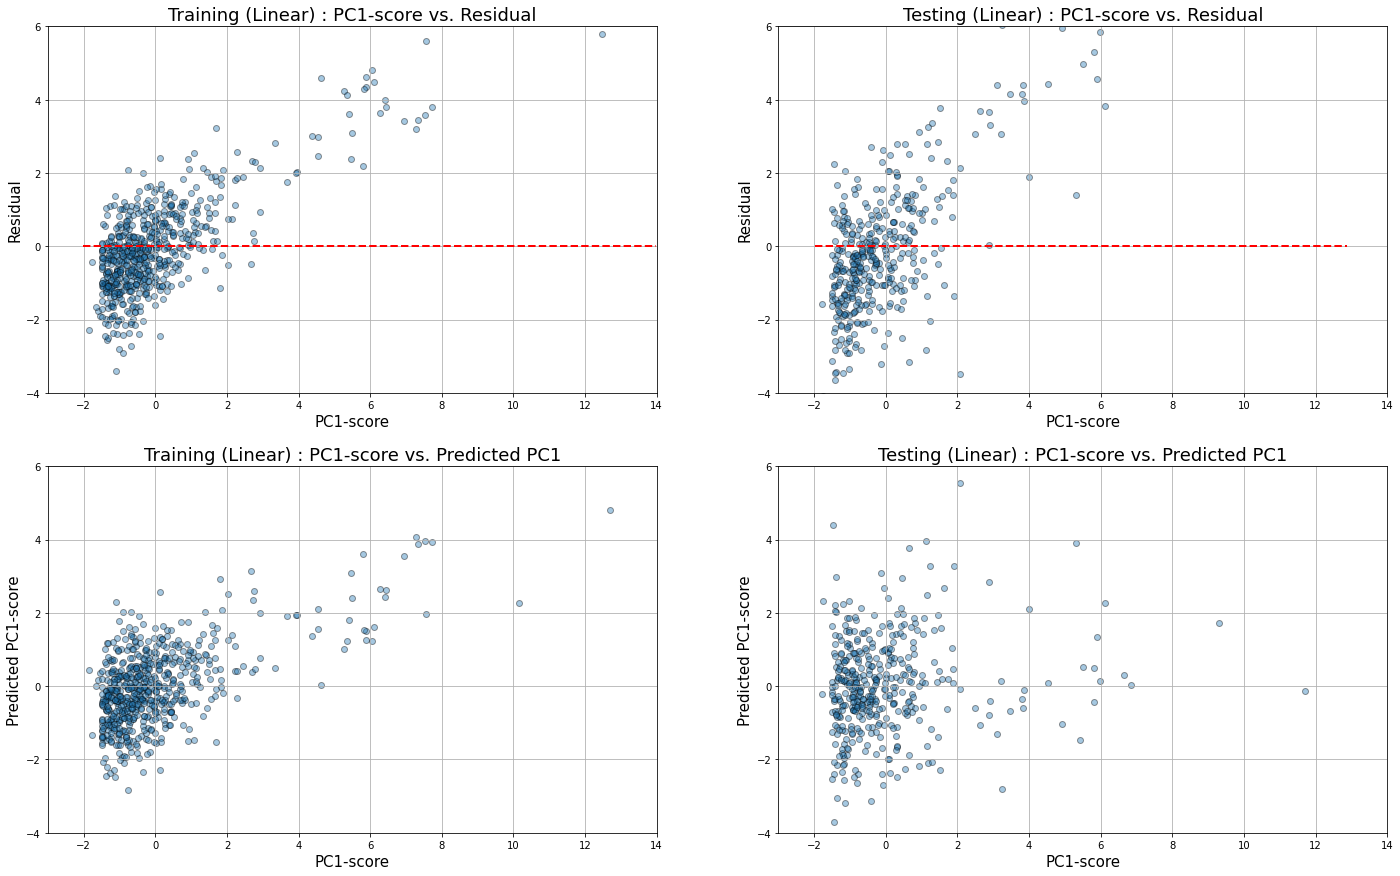

In [ ]:
resid = phs_pc_tr - phs_pc_tr_lr_pred
resid_te = phs_pc_te - phs_pc_te_lr_pred

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,14.833))

plot_reg(phs_pc_tr, resid, residual = True, dataset = 'Training (Linear)',
         a=-3, b=14, c=-4, d=6, e=0, f=0)

plot_reg(phs_pc_tr, phs_pc_tr_lr_pred, residual = False, dataset = 'Training (Linear)',
         a=-3, b=14, c=-4, d=6, e=1, f=0)

plot_reg(phs_pc_te,resid_te,True,'Testing (Linear)',
         a=-3, b=14, c=-4, d=6, e=0, f=1)

plot_reg(phs_pc_te,phs_pc_te_lr_pred,False,'Testing (Linear)',
         a=-3, b=14, c=-4, d=6, e=1, f=1)

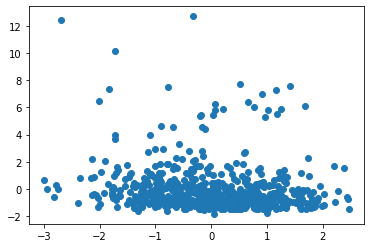

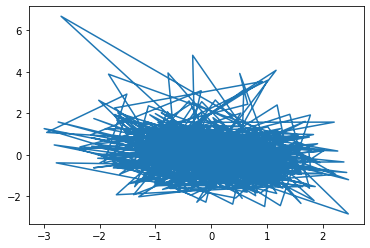

In [ ]:
plt.scatter(phs_tr[['CortexVol_Z_estimate']], phs_pc_tr)
plt.show()
plt.plot(phs_tr[['CortexVol_Z_estimate']], phs_pc_tr_lr_pred)
plt.show()

# 4.Lasso (Linear Regression + L1 Regularization)

In [ ]:
%%capture 
# LassoCV uses coordinate descent to select hyperparameter alpha
alpha_grid = np.array([10**a for a in np.arange(-3, 3, 0.01)])
lassoCV_model_z = linear_model.LassoCV(
    cv=5, 
    n_alphas=len(alpha_grid), 
    alphas=alpha_grid, 
    fit_intercept=True, 
    normalize=False, 
    random_state=50, 
    verbose=True, 
    n_jobs=5)
lassoCV_model_z.fit(phs_tr, phs_pc_tr)

In [ ]:
alpha_grid = np.array([10**a for a in np.arange(-5, 5, 0.1)])
alpha_grid.shape

(100,)

In [ ]:
lassoCV_model_z.alphas_

array([9.77237221e+02, 9.54992586e+02, 9.33254301e+02, 9.12010839e+02,
       8.91250938e+02, 8.70963590e+02, 8.51138038e+02, 8.31763771e+02,
       8.12830516e+02, 7.94328235e+02, 7.76247117e+02, 7.58577575e+02,
       7.41310241e+02, 7.24435960e+02, 7.07945784e+02, 6.91830971e+02,
       6.76082975e+02, 6.60693448e+02, 6.45654229e+02, 6.30957344e+02,
       6.16595002e+02, 6.02559586e+02, 5.88843655e+02, 5.75439937e+02,
       5.62341325e+02, 5.49540874e+02, 5.37031796e+02, 5.24807460e+02,
       5.12861384e+02, 5.01187234e+02, 4.89778819e+02, 4.78630092e+02,
       4.67735141e+02, 4.57088190e+02, 4.46683592e+02, 4.36515832e+02,
       4.26579519e+02, 4.16869383e+02, 4.07380278e+02, 3.98107171e+02,
       3.89045145e+02, 3.80189396e+02, 3.71535229e+02, 3.63078055e+02,
       3.54813389e+02, 3.46736850e+02, 3.38844156e+02, 3.31131121e+02,
       3.23593657e+02, 3.16227766e+02, 3.09029543e+02, 3.01995172e+02,
       2.95120923e+02, 2.88403150e+02, 2.81838293e+02, 2.75422870e+02,
      

In [ ]:
lassoCV_model_z.alpha_

0.18197008586097815

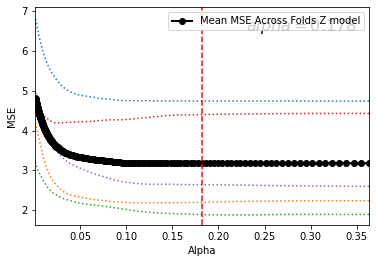

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(lassoCV_model_z.alphas_, lassoCV_model_z.mse_path_, ':')
plt.plot(lassoCV_model_z.alphas_, lassoCV_model_z.mse_path_.mean(axis=-1),
         color='k', marker='o', 
         label='Mean MSE Across Folds Z model', linewidth=2)
plt.axvline(x=lassoCV_model_z.alpha_, linestyle='--', c='r')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.xlim(lassoCV_model_z.alpha_*0.001,lassoCV_model_z.alpha_*2)
plt.text(0.23, 6.5, '$alpha = 0.178$', fontsize = 16)
plt.legend()
plt.show()

In [ ]:
# based on cv results above, set alpha=100
lasso_model_z = linear_model.Lasso(alpha=lassoCV_model_z.alpha_, 
                                   fit_intercept=True, normalize=False)
lasso_model_z.fit(phs_tr, phs_pc_tr)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


Lasso(alpha=0.18197008586097815, normalize=False)

In [ ]:
train_preds_lasso_model_z = lasso_model_z.predict(phs_tr)
test_preds_lasso_model_z = lasso_model_z.predict(phs_te)

train_r2_z = metrics.r2_score(phs_pc_tr, train_preds_lasso_model_z)
test_r2_z = metrics.r2_score(phs_pc_te, test_preds_lasso_model_z)
train_mae_z = metrics.mean_absolute_error(phs_pc_tr, train_preds_lasso_model_z)
test_mae_z = metrics.mean_absolute_error(phs_pc_te, test_preds_lasso_model_z)
train_mse_z = metrics.mean_squared_error(phs_pc_tr, train_preds_lasso_model_z)
test_mse_z = metrics.mean_squared_error(phs_pc_te, test_preds_lasso_model_z)

#train_r2_z = metrics.r2_score(phs_pc_te, test_preds_lasso_model_z)
print(f'Deviation model Train R^2: {train_r2_z:.3f}')
print(f'Deviation model Train R^2: {test_r2_z:.3f}')
print(f'Train MAE Z model: {train_mae_z:.3f}')
print(f'Test MAE Z model: {test_mae_z:.3f}')
print(f'Train MSE Z model: {train_mse_z:.3f}')
print(f'Test MSE Z model: {test_mse_z:.3f}')

Deviation model Train R^2: 0.016
Deviation model Train R^2: 0.011
Train MAE Z model: 1.096
Test MAE Z model: 1.070
Train MSE Z model: 3.116
Test MSE Z model: 2.669


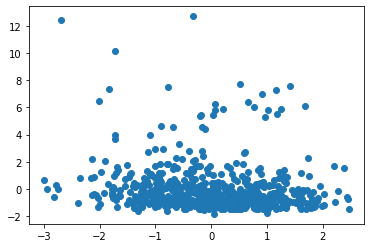

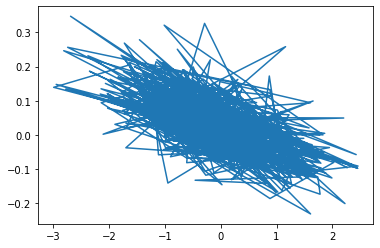

In [ ]:
plt.scatter(phs_tr[['CortexVol_Z_estimate']], phs_pc_tr)
plt.show()
plt.plot(phs_tr[['CortexVol_Z_estimate']], train_preds_lasso_model_z)
plt.show()

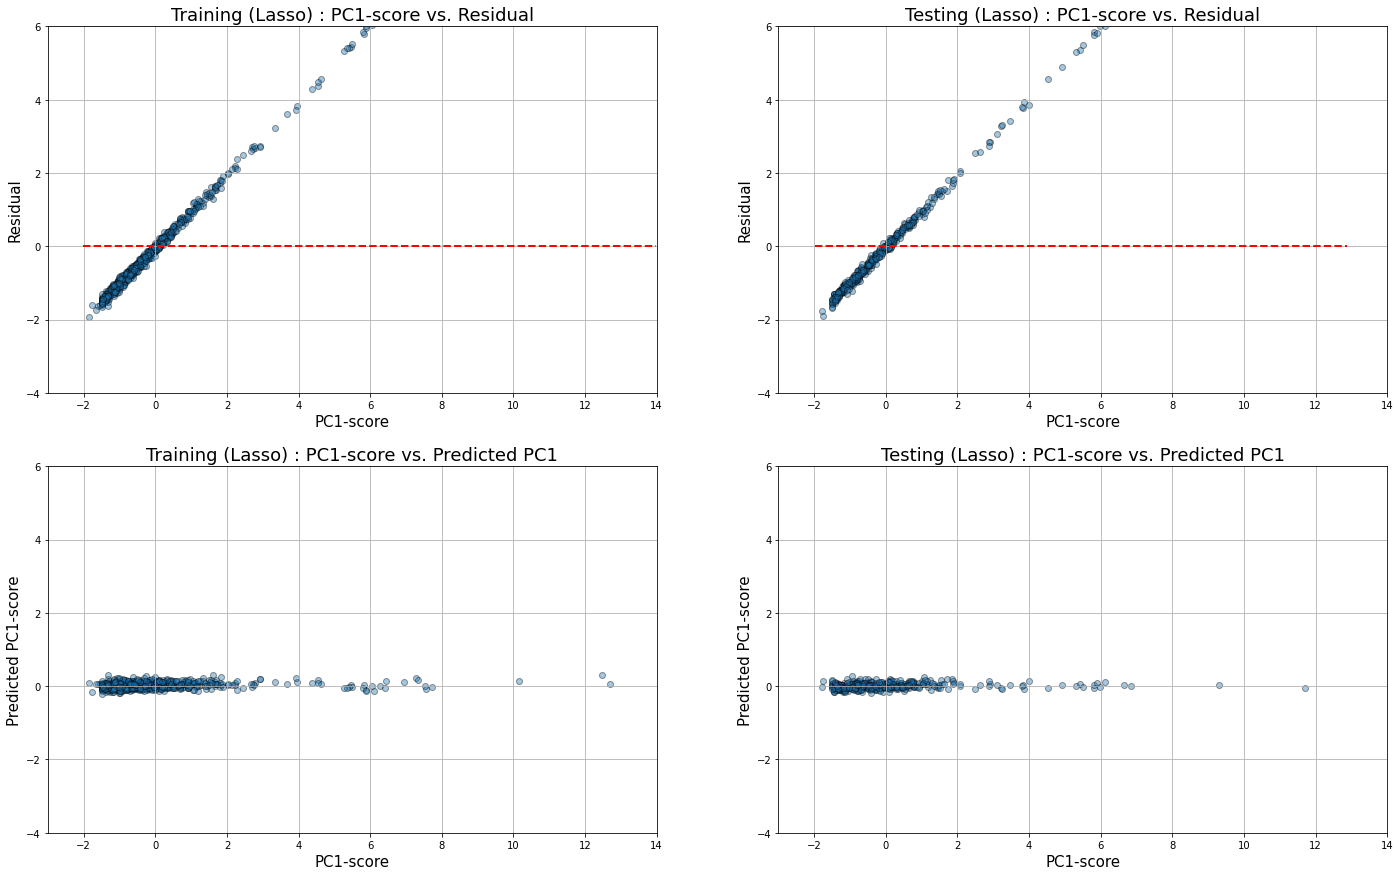

In [ ]:
resid_lasso = phs_pc_tr - train_preds_lasso_model_z.reshape(train_preds_lasso_model_z.shape[0],1)
resid_lasso_te = phs_pc_te - phs_pc_te_lr_pred

resid_lasso_te = phs_pc_te - test_preds_lasso_model_z.reshape(test_preds_lasso_model_z.shape[0],1)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,14.833))

plot_reg(phs_pc_tr,resid_lasso, residual = True, dataset = 'Training (Lasso)',
         a=-3, b=14, c=-4, d=6, e=0, f=0)

plot_reg(phs_pc_tr,train_preds_lasso_model_z, residual = False, dataset = 'Training (Lasso)',
         a=-3, b=14, c=-4, d=6, e=1, f=0)

plot_reg(phs_pc_te,resid_lasso_te,True,'Testing (Lasso)',
         a=-3, b=14, c=-4, d=6, e=0, f=1)

plot_reg(phs_pc_te,test_preds_lasso_model_z,False,'Testing (Lasso)',
         a=-3, b=14, c=-4, d=6, e=1, f=1)

# 5.Ridge (Linear Regression + L2 Regularization)

In [ ]:
alpha_grid 

array([1.00000000e-03, 1.25892541e-03, 1.58489319e-03, 1.99526231e-03,
       2.51188643e-03, 3.16227766e-03, 3.98107171e-03, 5.01187234e-03,
       6.30957344e-03, 7.94328235e-03, 1.00000000e-02, 1.25892541e-02,
       1.58489319e-02, 1.99526231e-02, 2.51188643e-02, 3.16227766e-02,
       3.98107171e-02, 5.01187234e-02, 6.30957344e-02, 7.94328235e-02,
       1.00000000e-01, 1.25892541e-01, 1.58489319e-01, 1.99526231e-01,
       2.51188643e-01, 3.16227766e-01, 3.98107171e-01, 5.01187234e-01,
       6.30957344e-01, 7.94328235e-01, 1.00000000e+00, 1.25892541e+00,
       1.58489319e+00, 1.99526231e+00, 2.51188643e+00, 3.16227766e+00,
       3.98107171e+00, 5.01187234e+00, 6.30957344e+00, 7.94328235e+00,
       1.00000000e+01, 1.25892541e+01, 1.58489319e+01, 1.99526231e+01,
       2.51188643e+01, 3.16227766e+01, 3.98107171e+01, 5.01187234e+01,
       6.30957344e+01, 7.94328235e+01, 1.00000000e+02, 1.25892541e+02,
       1.58489319e+02, 1.99526231e+02, 2.51188643e+02, 3.16227766e+02,
      

In [ ]:
%%capture
#8/7
alpha_grid = np.array([10**a for a in np.arange(-3, 3, 0.01)])
ridgeCV_model_z = linear_model.RidgeCV(
    cv=5, 
    #n_alphas=len(alpha_grid), 
    alphas=alpha_grid, 
    fit_intercept=True, 
    normalize=False, 
    #random_state=42, 
    #verbose=True, n_jobs=5
    )
ridgeCV_model_z.fit(phs_tr, phs_pc_tr)

In [ ]:
# RidgeCV uses generalized cross validation to select hyperparameter alpha
with warnings.catch_warnings():
    # ignore matrix decomposition errors
    warnings.simplefilter("ignore")
    ridgeCV_model_z = linear_model.RidgeCV(
        alphas=(0.1, 1.0, 10.0), 
        fit_intercept=True, 
        normalize=False, 
        cv=5).fit(phs_tr, phs_pc_tr)

In [ ]:
ridge_alpha_z = ridgeCV_model_z.alpha_
print(f'CV Selected Alpha Z model = {ridge_alpha_z:.3f}')

CV Selected Alpha Z model = 977.237


In [ ]:
ridgeCV_model_z.alpha_

977.2372209555234

In [ ]:
ridgeCV_model_z.alphas_

AttributeError: ignored

In [ ]:
ridgeCV_model_z.mse_path_

AttributeError: ignored

In [ ]:
ridge_model_z = linear_model.Ridge(alpha=ridge_alpha_z, fit_intercept=True, normalize=False).fit(phs_tr, phs_pc_tr)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(ridgeCV_model_z.alphas_, ridgeCV_model_z.mse_path_, ':')
plt.plot(ridgeCV_model_z.alphas_, ridgeCV_model_z.mse_path_.mean(axis=-1), color='k', marker='o', label='Mean MSE Across Folds Z model', linewidth=2)
plt.axvline(x=lassoCV_model_z.alpha_, linestyle='--', c='r')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.xlim(ridgeCV_model_z.alpha_*0.001,ridgeCV_model_z.alpha_*2)
plt.text(0.23, 6.5, '$alpha = 0.178$', fontsize = 16)
plt.legend()
plt.show()

In [ ]:
train_preds_ridge_model_z = ridge_model_z.predict(phs_tr)
test_preds_ridge_model_z = ridge_model_z.predict(phs_te)

train_r2_z = metrics.r2_score(phs_pc_tr, train_preds_ridge_model_z)
test_r2_z = metrics.r2_score(phs_pc_te, test_preds_ridge_model_z)
train_mae_z = metrics.mean_absolute_error(phs_pc_tr, train_preds_ridge_model_z)
test_mae_z = metrics.mean_absolute_error(phs_pc_te, test_preds_ridge_model_z)
train_mse_z = metrics.mean_squared_error(phs_pc_tr, train_preds_ridge_model_z)
test_mse_z = metrics.mean_squared_error(phs_pc_te, test_preds_ridge_model_z)


print(f'Deviation model Train R^2: {train_r2_z:.3f}')
print(f'Deviation model Train R^2: {test_r2_z:.3f}')
print(f'Deviation model Train MAE: {train_mae_z:.3f}')
print(f'Deviation model Test MAE: {test_mae_z:.3f}')
print(f'Deviation model Train MSE: {train_mse_z:.3f}')
print(f'Deviation model Test MSE: {test_mse_z:.3f}')

Deviation model Train R^2: 0.164
Deviation model Train R^2: 0.034
Deviation model Train MAE: 1.023
Deviation model Test MAE: 1.038
Deviation model Train MSE: 2.649
Deviation model Test MSE: 2.607


In [ ]:
resid_ridge = phs_pc_tr - train_preds_ridge_model_z.reshape(train_preds_ridge_model_z.shape[0],1)
resid_ridge_te = phs_pc_te - test_preds_ridge_model_z.reshape(test_preds_ridge_model_z.shape[0],1)



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,14.833))

plot_reg(phs_pc_tr,resid_ridge, residual = True, dataset = 'Training (Ridge)',
         a=-3, b=14, c=-4, d=6, e=0, f=0)

plot_reg(phs_pc_tr,train_preds_ridge_model_z, residual = False, dataset = 'Training (Ridge)',
         a=-3, b=14, c=-4, d=6, e=1, f=0)

plot_reg(phs_pc_te,resid_ridge_te,True,'Testing (Ridge)',
         a=-3, b=14, c=-4, d=6, e=0, f=1)

plot_reg(phs_pc_te,test_preds_ridge_model_z,False,'Testing (Ridge)',
         a=-3, b=14, c=-4, d=6, e=1, f=1)

# Visualize Lasso and Ridge to PolynomialFeatures

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [ ]:
# based on cv results above, set alpha=100
#lasso_model_z = linear_model.Lasso(alpha=lassoCV_model_z.alpha_, fit_intercept=True, normalize=False)
#lasso_model_z.fit(phs_tr, phs_pc_tr)


roi = 'CortexVol_Z_estimate'
X = phs_tr[[roi]].to_numpy().reshape(phs_tr[[roi]].shape[0],1)
X_new = phs_te[[roi]].to_numpy().reshape(phs_te[[roi]].shape[0],1)
y = phs_pc_tr.to_numpy().reshape(phs_pc_tr.shape[0],1)


def plot_model(model_class, polynomial, alphas, **model_kargs):
    plt.plot(X, y, "c.", markersize=12)
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=2, label=r"$\alpha = {}$".format(alpha))
    #plt.plot(X, y, "c.", markersize=12)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel(roi, fontsize=18)
    #plt.ylabel("PC1", fontsize=18)
    plt.ylabel("$PC1$", rotation=0, fontsize=18)
    plt.axis([min(X)*1.1, max(X)*1.1, min(y)*1.1, max(y)*1.1])

plt.figure(figsize=(28,10))
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, lassoCV_model_z.alpha_, 0.35), random_state=42)
#plt.ylabel("$y$", rotation=0, fontsize=18)
#save_fig("ridge_regression_plot")
plt.show()

In [ ]:
# based on cv results above, set alpha=100
#lasso_model_z = linear_model.Lasso(alpha=lassoCV_model_z.alpha_, fit_intercept=True, normalize=False)
#lasso_model_z.fit(phs_tr, phs_pc_tr)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=5, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])


plt.figure(figsize=(18,10))
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
#save_fig("ridge_regression_plot")
plt.show()

# 6.Elastic Net (Linear Regression + L1/L2 Regularization)

In [ ]:
%%capture
# RidgeCV uses generalized cross validation to select hyperparameter alpha
alpha_grid = np.array([10**a for a in np.arange(-3, 3, 0.15)])
elasticnetCV_model = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_alphas=len(alpha_grid), alphas=alpha_grid, random_state=42, verbose=True, n_jobs=5)
elasticnetCV_model.fit(phs_tr, phs_pc_tr)

In [ ]:
%%capture
# RidgeCV uses generalized cross validation to select hyperparameter alpha
elasticnetCV_model = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, n_alphas=len(alpha_grid), alphas=alpha_grid, random_state=42, verbose=True, n_jobs=5)
elasticnetCV_model.fit(phs_tr, phs_pc_tr)

In [ ]:
print(f'CV selected alpha Z model {elasticnetCV_model.alpha_:.3f}')
print(f'Elastic net L1 ratio Z model {elasticnetCV_model.l1_ratio_:.3f}')
#print(f'CV selected alpha CT model {elasticnetCV_model_ct.alpha_:.3f}')
#print(f'Elastic net L1 ratio CT model {elasticnetCV_model_ct.l1_ratio_:.3f}')

CV selected alpha Z model 1.000
Elastic net L1 ratio Z model 0.100


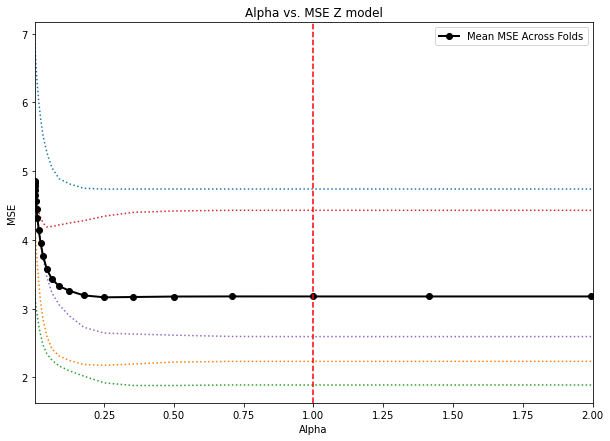

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(elasticnetCV_model.alphas_, elasticnetCV_model.mse_path_[1, :, :], ':')
plt.plot(elasticnetCV_model.alphas_, elasticnetCV_model.mse_path_[1, :, :].mean(axis=-1), color='k', marker='o', label='Mean MSE Across Folds', linewidth=2)
plt.axvline(x=elasticnetCV_model.alpha_, linestyle='--', c='r')
plt.xlim(elasticnetCV_model.alpha_*0.001,elasticnetCV_model.alpha_*2)
plt.title('Alpha vs. MSE Z model')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
elasticnet_model_z = linear_model.ElasticNet(alpha=elasticnetCV_model.alpha_, l1_ratio=elasticnetCV_model.l1_ratio_, fit_intercept=True, normalize=False, random_state=42).fit(phs_tr, phs_pc_tr)

train_preds_en_model_z = elasticnet_model_z.predict(phs_tr)
test_preds_en_model_z = elasticnet_model_z.predict(phs_te)

train_r2_z = metrics.r2_score(phs_pc_tr, train_preds_en_model_z)
test_r2_z = metrics.r2_score(phs_pc_te, test_preds_en_model_z)
train_mae_z = metrics.mean_absolute_error(phs_pc_tr, train_preds_en_model_z)
test_mae_z = metrics.mean_absolute_error(phs_pc_te, test_preds_en_model_z)
train_mse_z = metrics.mean_squared_error(phs_pc_tr, train_preds_en_model_z)
test_mse_z = metrics.mean_squared_error(phs_pc_te, test_preds_en_model_z)

#train_r2_z = metrics.r2_score(phs_pc_te, test_preds_lasso_model_z)
print(f'Deviation model Train R^2: {train_r2_z:.3f}')
print(f'Deviation model Train R^2: {test_r2_z:.3f}')
print(f'Train MAE Z model: {train_mae_z:.3f}')
print(f'Test MAE Z model: {test_mae_z:.3f}')
print(f'Train MSE Z model: {train_mse_z:.3f}')
print(f'Test MSE Z model: {test_mse_z:.3f}')

Deviation model Train R^2: 0.051
Deviation model Train R^2: 0.025
Train MAE Z model: 1.076
Test MAE Z model: 1.053
Train MSE Z model: 3.007
Test MSE Z model: 2.631


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


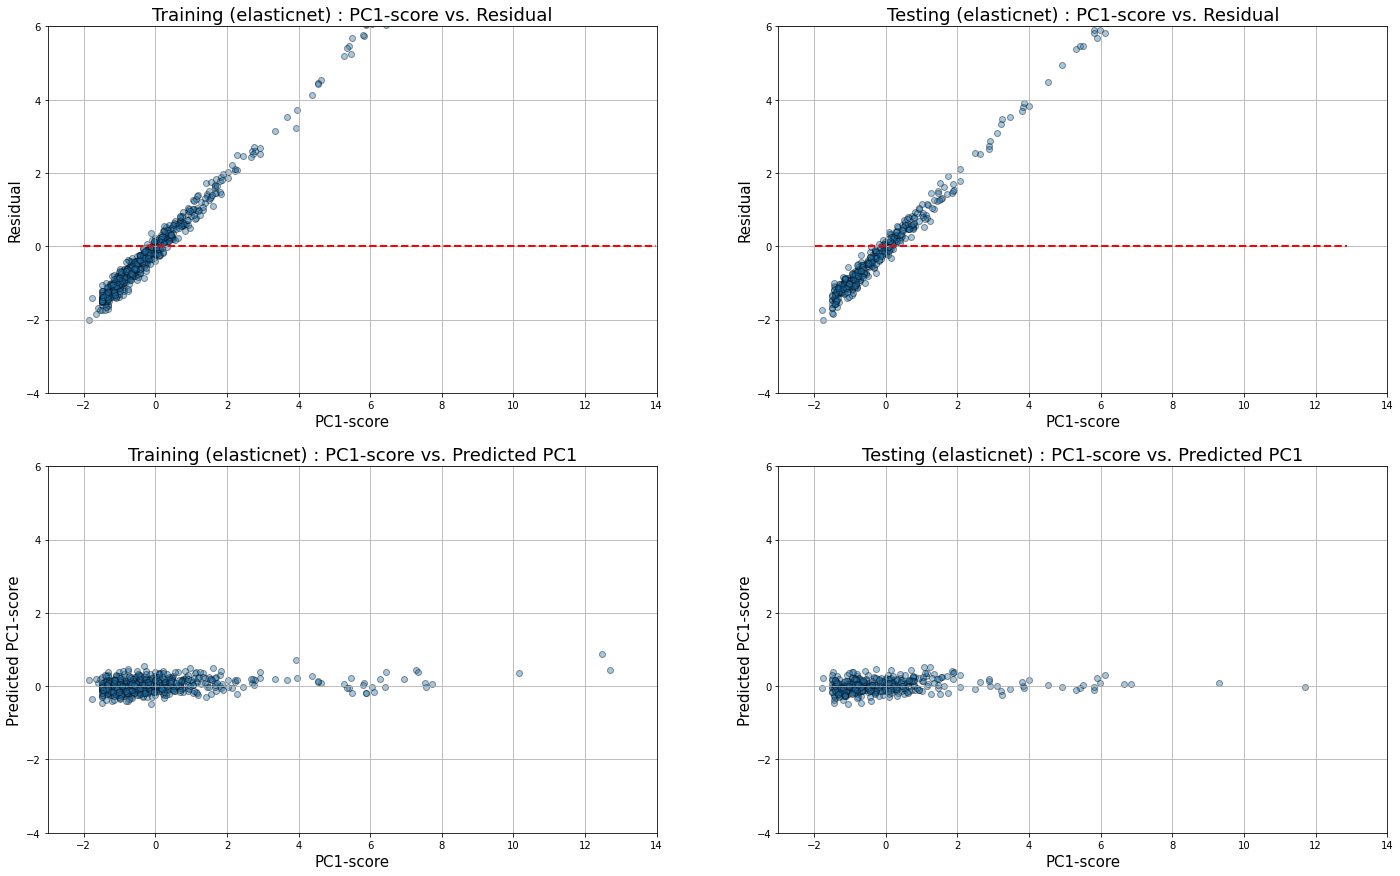

In [ ]:
resid_en = phs_pc_tr - train_preds_en_model_z.reshape(train_preds_ridge_model_z.shape[0],1)
resid_en_te = phs_pc_te - test_preds_en_model_z.reshape(test_preds_ridge_model_z.shape[0],1)



fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24,14.833))

plot_reg(phs_pc_tr,resid_en, residual = True, dataset = 'Training (elasticnet)',
         a=-3, b=14, c=-4, d=6, e=0, f=0)

plot_reg(phs_pc_tr,train_preds_en_model_z, residual = False, dataset = 'Training (elasticnet)',
         a=-3, b=14, c=-4, d=6, e=1, f=0)

plot_reg(phs_pc_te,resid_en_te,True,'Testing (elasticnet)',
         a=-3, b=14, c=-4, d=6, e=0, f=1)

plot_reg(phs_pc_te,test_preds_en_model_z,False,'Testing (elasticnet)',
         a=-3, b=14, c=-4, d=6, e=1, f=1)

# 8.Using transformed data with PCA

First PC explains 20.29% of the total variance.


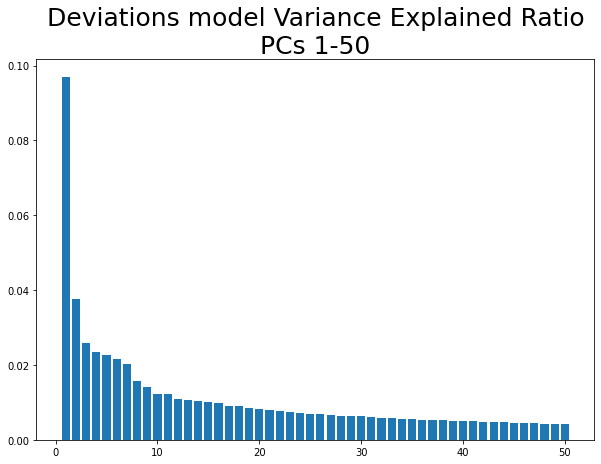

In [ ]:
# Compute PCA
pca_model_z = decomposition.PCA(n_components=75).fit(phs_tr)
# from pca documentation, "the input data is centered but not scaled for each feature before applying the SVD"
print(f'First PC explains {pca_model_z.explained_variance_ratio_[0]*100:.2f}% of the total variance.')
plt.figure(figsize=(10, 7))
plt.bar(range(1, 51), pca_model_z.explained_variance_ratio_[1:51])
plt.title('Deviations model Variance Explained Ratio\nPCs 1-50', fontsize=25)
plt.show()

In [ ]:
# Computaing reduced dimentional training + testing dataset:
phs_tr_tf = pca_model_z.transform(phs_tr)
phs_te_tf = pca_model_z.transform(phs_te)

In [ ]:
# OLS using sklearn on tranformed model:
lr_model = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lr_model.fit(phs_tr_tf, phs_pc_tr)
phs_pc_tr_lr_pred = lr_model.predict(phs_tr_tf)
phs_pc_te_lr_pred = lr_model.predict(phs_te_tf)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


In [ ]:
train_r2_z = metrics.r2_score(phs_pc_tr, phs_pc_tr_lr_pred)
train_mae_z = metrics.mean_absolute_error(phs_pc_tr, phs_pc_tr_lr_pred)
test_mae_z = metrics.mean_absolute_error(phs_pc_te, phs_pc_te_lr_pred)
train_mae_z = metrics.mean_squared_error(phs_pc_tr, phs_pc_tr_lr_pred)
test_mae_z = metrics.mean_squared_error(phs_pc_te, phs_pc_te_lr_pred)
print(f'Deviation model Train R^2: {train_r2_z:.3f}')
print(f'Deviation model Train MAE: {train_mae_z:.3f}')
print(f'Deviation model Test MAE: {test_mae_z:.3f}')
print(f'Deviation model Train MSE: {train_mae_z:.3f}')
print(f'Deviation model Test MSE: {test_mae_z:.3f}')

Deviation model Train R^2: 0.160
Deviation model Train MAE: 2.659
Deviation model Test MAE: 2.872
Deviation model Train MSE: 2.659
Deviation model Test MSE: 2.872
